# task1 PyTorch的基本概念

## 安装

参考
[WIn10+Anaconda 环境下安装 PyTorch 避坑指南](https://blog.csdn.net/red_stone1/article/details/86669362)

```
# Python 3.6
pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-win_amd64.whl
pip3 install torchvision
```

虽然本来安装了anaconda，但是最后还是用pip安装成功的，不过没有出现参考文章中import torchvision 报错的情况，直接就成功了

In [1]:
import torch
import torchvision
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable


## 自动微分(Automatic Differentiation)简介

参考[自动微分(Automatic Differentiation)简介](https://blog.csdn.net/aws3217150/article/details/70214422)

考察如下函数：
$f\left(x_{1}, x_{2}\right)=\ln \left(x_{1}\right)+x_{1} x_{2}-\sin \left(x_{2}\right)$


### 自动微分Forward Mode

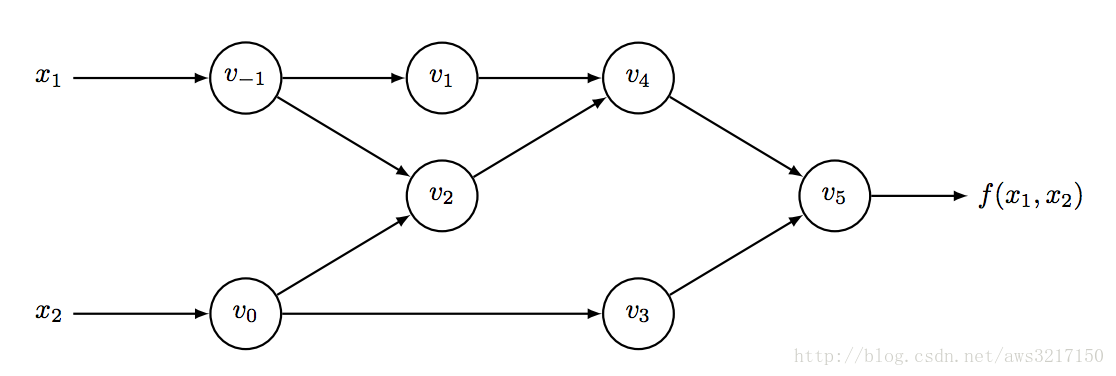

左半部分是从左往右每个图节点的求值结果，右半部分是每个节点对于${x_{1}}$的求导结果

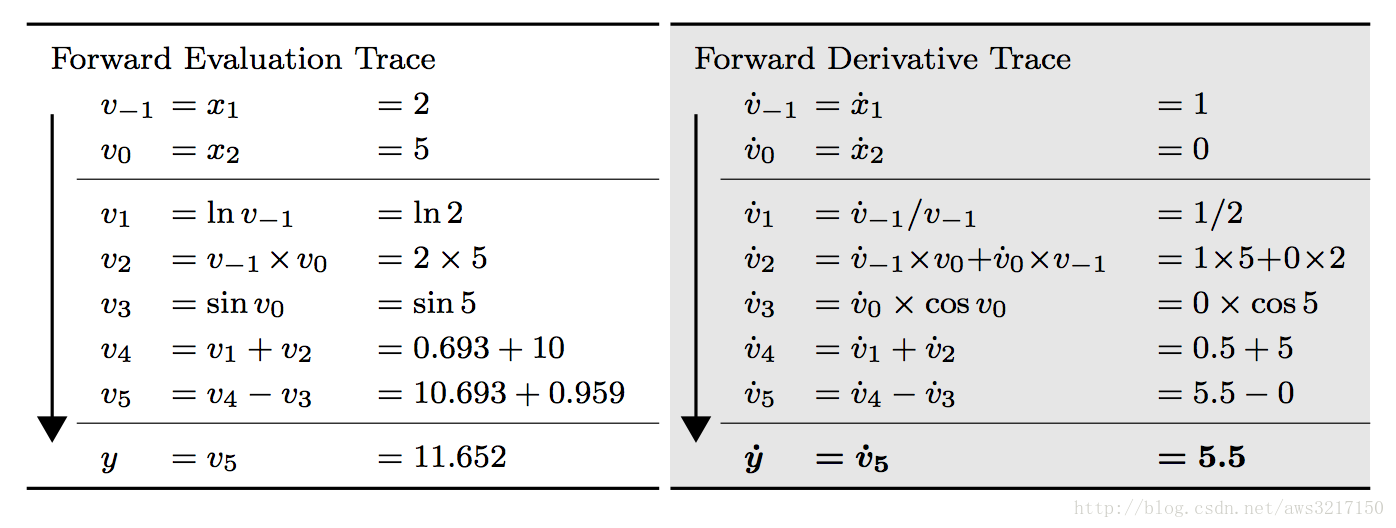

### 自动微分Reverse Mode

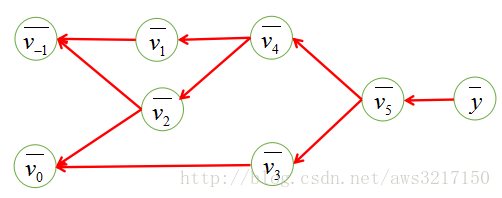

注意必须从下网上看，也就是一开始先计算输出${y}$对于节点${v_{5}}$的导数，用$\overline{v}_{5}$
表示$\frac{d y}{d v_{5}}$，这样的记号可以强调我们对当前计算结果进行缓存，以便用于后续计算

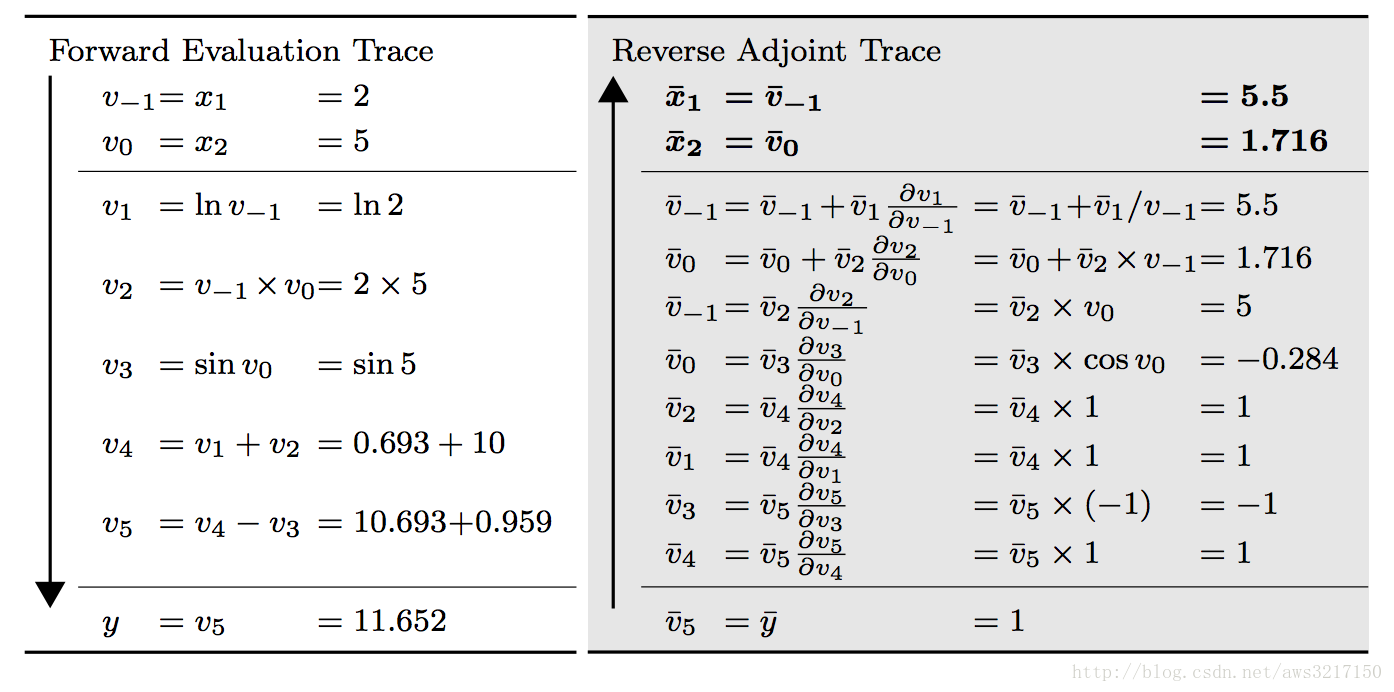

因为神经网络一般输入节点多，输出节点少，所以用Reverse Mode会快一些

## 简单操作

创建一个没有初始化的5*3矩阵：

In [2]:
x = torch.empty(5, 3)
print(x)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.3340e-42, 0.0000e+00],
        [0.0000e+00, 4.4810e+30, 0.0000e+00]])


实现一个只有输入层、单隐藏层、输出层的一个神经网络。假设样本数为64个，输入维度为1000，隐藏层为100，输出层为10。

参考[简单神经网络在Numpy和Pytorch上的实现](https://blog.csdn.net/herosunly/article/details/88949873)

In [3]:
num_samples = 64 # N
dim_in, dim_hid, dim_out = 1000, 100, 10  # IN H OUT
x = torch.randn(num_samples, dim_in)  #  N * IN
y = torch.randn(num_samples, dim_out) #  N * OUT

w1 = torch.randn(dim_in, dim_hid)     # IN * H
w2 = torch.randn(dim_hid, dim_out)    #  H * OUT

eta = 1e-6
for i in range(100):
    #Forward pass
    h = x @ w1                              # N * H
    h_relu = h.clamp(min = 0)               # N * H
    y_pred = h_relu @ w2                    # N * OUT

    #Loss
    loss = (y_pred - y).pow(2).sum().item()
    print('times is {}, loss is {}'.format(i, loss))

    #Backward pass
    grad_y_pred = 2.0 * (y_pred - y)        # N * OUT
    grad_w2 = (h_relu.t()) @ (grad_y_pred) #H * OUT = (H * N) * (N * OUT)，其中(H * N) = (N * H).T

    grad_h_relu = grad_y_pred @ ((w2.t()))# N * H = (N * OUT) * (OUT * H)，其中(OUT * H) = (H * OUT).T
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0

    grad_w1 = (x.t()) @ (grad_h)  # IN * H = （IN * N） * (N * H)

    w1 = w1 - eta * grad_w1
    w2 = w2 - eta * grad_w2

times is 0, loss is 27274294.0
times is 1, loss is 20173400.0
times is 2, loss is 16992264.0
times is 3, loss is 14946633.0
times is 4, loss is 12974883.0
times is 5, loss is 10754442.0
times is 6, loss is 8442926.0
times is 7, loss is 6302774.0
times is 8, loss is 4544051.0
times is 9, loss is 3216244.0
times is 10, loss is 2275754.25
times is 11, loss is 1629398.875
times is 12, loss is 1192330.25
times is 13, loss is 895365.75
times is 14, loss is 691564.0
times is 15, loss is 548771.9375
times is 16, loss is 446226.25
times is 17, loss is 370414.625
times is 18, loss is 312785.09375
times is 19, loss is 267841.96875
times is 20, loss is 231970.3125
times is 21, loss is 202714.015625
times is 22, loss is 178443.796875
times is 23, loss is 158024.484375
times is 24, loss is 140630.625
times is 25, loss is 125667.0078125
times is 26, loss is 112697.765625
times is 27, loss is 101390.515625
times is 28, loss is 91466.4375
times is 29, loss is 82720.1328125
times is 30, loss is 74992.71

# task2 设立计算图并自动计算

## 一、线性回归 y = w1*x1 + w2*x2

In [4]:
w1 = 4
w2 = -3

${loss}=\frac{1}{2n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}$

$\frac{dloss}{d w_{1}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{1_{i}}$

$\frac{dloss}{d w_{2}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{2_{i}}$

### 1、numpy方式

In [6]:
x_data = np.array([[1,2,3],
                   [3,1,2]])
y_data = w1 * x_data[0] + w2 * x_data[1]

In [7]:
y_data

array([-5,  5,  6])

In [8]:
epochs = 10
rate = 0.1
w1_ = 0
w2_ = 0
cost = []

In [9]:
for epoch in range(epochs):
    y_ = w1_ * x_data[0] + w2_ * x_data[1]
    #print(y_)
    #计算损失
    loss = np.average((y_ - y_data)**2)/2.0
    cost.append(loss)
    
    #计算梯度
    dw1 = (y_ - y_data) @ x_data[0].T/(x_data.shape[1])
    dw2 = (y_ - y_data) @ x_data[1].T/(x_data.shape[1])
    #print(dw1,dw2)
    #参数更新
    w1_ = w1_ - rate * dw1
    w2_ = w2_ - rate * dw2
    print(w1_,w2_)

0.7666666666666667 0.06666666666666667
1.1511111111111112 -0.17888888888888888
1.4461851851851852 -0.4508148148148148
1.7032641975308642 -0.7040358024691358
1.9332206995884773 -0.9333493004115226
2.1399457832647464 -1.1399672167352537
2.3259590638774577 -1.3259626361225423
2.4933644673129094 -1.4933650626870905
2.6440282388854848 -1.6440283381145149
2.7796254513809138 -1.7796254679190857


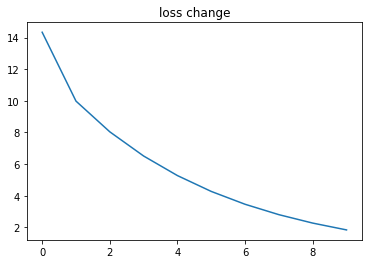

In [10]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

### 2、torch 方式

In [12]:
torch.manual_seed(2)

In [13]:
x_data = Variable(torch.Tensor([[1.0,3.0],[2.0,1.0],[3.0,2.0]]))
y_data = Variable(torch.Tensor([[-5.0],[5.0],[6.0]]))

In [14]:
x_data

tensor([[1., 3.],
        [2., 1.],
        [3., 2.]])

In [15]:
y_data

tensor([[-5.],
        [ 5.],
        [ 6.]])

In [16]:
epochs = 10
rate = 0.1
w = Variable(torch.FloatTensor([[0],[0]]))
w.requires_grad_(True)
cost = []

In [17]:
for epoch in range(epochs):
    y_ = x_data.mm(w)
    #print(y_)
    loss = ((y_ - y_data)**2).mean()/2.0
    cost.append(float(loss.data))
    loss.backward()
    w.data = w.data - rate * w.grad.data
    
    #print(w.grad.data)
    #这一步很关键，必须清零，因为 .grad这个属性值是累加的
    w.grad.data.zero_()
    print(w.data)

tensor([[0.7667],
        [0.0667]])
tensor([[ 1.1511],
        [-0.1789]])
tensor([[ 1.4462],
        [-0.4508]])
tensor([[ 1.7033],
        [-0.7040]])
tensor([[ 1.9332],
        [-0.9333]])
tensor([[ 2.1399],
        [-1.1400]])
tensor([[ 2.3260],
        [-1.3260]])
tensor([[ 2.4934],
        [-1.4934]])
tensor([[ 2.6440],
        [-1.6440]])
tensor([[ 2.7796],
        [-1.7796]])


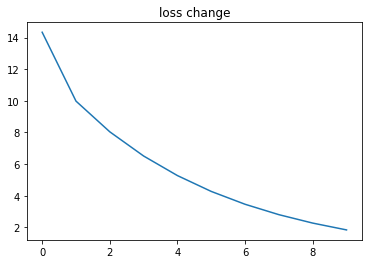

In [18]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

# task3 PyTorch实现Logistic regression

参考[Pytorch实现逻辑回归](https://blog.csdn.net/herosunly/article/details/89130368)

## 公式推导

$\hat{y}_{i}=\frac{1}{1+e^{-\left(w \cdot x_{i}+b\right)}}$

极大似然思想

$maxL=\prod_{i=1}^{N} \hat{y}_{i}^{y_{i}} \cdot\left(1-\hat{y}_{i}\right)^{\left(1-{y_{i}}\right)}$

$max\ln L=\sum_{i=1}^{N} y_{i} \ln \hat{y}_{i}+\left(1-y_{i}\right) \ln \left(1-\hat{y}_{i}\right)$

$\max \ln L=\min(-\ln L)$

## 一、PyTorch基础实现代码

In [150]:
import random
import torch.nn as nn

seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [86]:
x_data = torch.Tensor([[0.1,0.3],[0.2,0.6],[0.2,0.8],[0.4,0.7],[0.4,0.2],[0.6,0.4],[0.6,0.6],[0.8,0.8],[1,0.4]])
y_data = torch.Tensor([[1],[1],[1],[1],[0],[0],[0],[0],[0]])

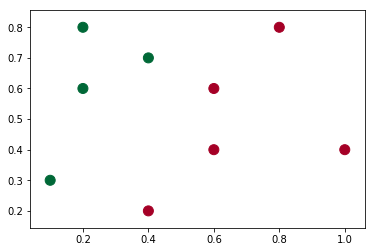

In [92]:
plt.figure()
plt.scatter(x_data.data.numpy()[:, 0], x_data.data.numpy()[:, 1], c=y_data.data.numpy().reshape(1,9)[0], s=100, cmap='RdYlGn')
plt.show()

#### 用torch来构造随机数据

In [180]:
center_data = torch.ones(100, 2)
x0 = torch.normal(mean=center_data+2, std=1) #得到正太数据
y0 = torch.zeros(center_data.shape[0],1) #设定为 0 label
x1 = torch.normal(mean=center_data-2, std=1) #得到正太数据
y1 = torch.ones(center_data.shape[0],1) #设定为 1 label
x_data = torch.cat((x0,x1),0).type(torch.FloatTensor)
y_data = torch.cat((y0,y1),0).type(torch.FloatTensor)

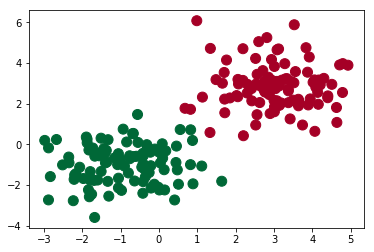

In [181]:
plt.figure()
plt.scatter(x_data.data.numpy()[:, 0], x_data.data.numpy()[:, 1], c=y_data.data.numpy().reshape(1,2*center_data.shape[0])[0], s=100, cmap='RdYlGn')
plt.show()

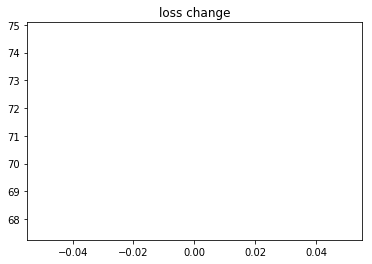

In [196]:
dim_in = x_data.shape[1] # IN
dim_out = 1  # OUT
x_data = Variable(x_data)
y_data = Variable(y_data)
w = torch.randn(dim_in, dim_out, requires_grad=True)     # IN * OUT
b = torch.randn(dim_out, requires_grad=True)                  #bias，偏置项

eta = 0.1
epochs = 100
loss_ = []
w_ = []
for epoch in range(epochs):
    #Forward pass
    w_.append(w.data)
    h = x_data @ w + b  
    fun = nn.Sigmoid()
    y_pred = fun(h)                                    #sigmod激活函数
    #print(y_pred)
    #Loss
    loss = -torch.sum(y_data * torch.log(y_pred) + (1 - y_data) * torch.log(1 - y_pred)) 
    #print('epoch is {}, loss is {}'.format(epoch, loss.item()))
    loss_.append(float(loss.data))
    loss.backward()

    w.data = w.data - eta * w.grad.data
    b.data = b.data - eta * b.grad.data
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    
plt.figure()
plt.plot(range(epochs), loss_)
plt.title(u"loss change")
plt.show()

In [198]:
w_

[tensor([[-0.6953],
         [-0.3675]]), tensor([[-3.9381],
         [-4.6498]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [nan]]), tensor([[nan],
         [n

In [197]:
loss_

[71.1711654663086,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

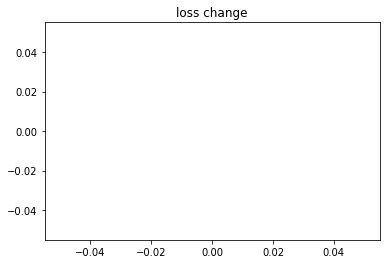

In [183]:
dim_in = x_data.shape[1] # IN
dim_out = 1  # OUT

#w = torch.randn(dim_in, dim_out, requires_grad=True)     # IN * OUT
b = torch.randn(dim_out, requires_grad=True)                  #bias，偏置项

w = Variable(torch.FloatTensor([[10],[-4]]))
w.requires_grad_(True)
eta = 0.1
epochs = 1000
loss_ = []
w_ = []
for epoch in range(epochs):
    #Forward pass
    w_.append(w.data)
    h = x_data @ w + b                                                    
    y_pred = 1 / (1 + torch.exp(-h))                                    #sigmod激活函数

    #Loss
    loss = -torch.sum(y_data * torch.log(y_pred) + (1 - y_data) * torch.log(1 - y_pred)) 
    #print('epoch is {}, loss is {}'.format(epoch, loss.item()))
    loss_.append(float(loss.data))
    loss.backward()

    w.data = w.data - eta * w.grad.data
    b.data = b.data - eta * b.grad.data
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    
plt.figure()
plt.plot(range(epochs), loss_)
plt.title(u"loss change")
plt.show()

In [27]:
loss_[-1]

0.5120936632156372

In [28]:
w_

[tensor([[10.],
         [-4.]]), tensor([[ 9.6937],
         [-4.1385]]), tensor([[ 9.3980],
         [-4.2512]]), tensor([[ 9.1132],
         [-4.3407]]), tensor([[ 8.8395],
         [-4.4094]]), tensor([[ 8.5770],
         [-4.4597]]), tensor([[ 8.3257],
         [-4.4937]]), tensor([[ 8.0856],
         [-4.5129]]), tensor([[ 7.8566],
         [-4.5188]]), tensor([[ 7.6383],
         [-4.5128]]), tensor([[ 7.4301],
         [-4.4961]]), tensor([[ 7.2310],
         [-4.4700]]), tensor([[ 7.0402],
         [-4.4358]]), tensor([[ 6.8566],
         [-4.3948]]), tensor([[ 6.6794],
         [-4.3481]]), tensor([[ 6.5075],
         [-4.2965]]), tensor([[ 6.3402],
         [-4.2411]]), tensor([[ 6.1768],
         [-4.1825]]), tensor([[ 6.0167],
         [-4.1214]]), tensor([[ 5.8595],
         [-4.0583]]), tensor([[ 5.7047],
         [-3.9936]]), tensor([[ 5.5520],
         [-3.9277]]), tensor([[ 5.4011],
         [-3.8608]]), tensor([[ 5.2519],
         [-3.7933]]), tensor([[ 5.1042],
    

In [29]:
w

tensor([[-14.9018],
        [  7.9678]], requires_grad=True)

In [30]:
b

tensor([1.9999], requires_grad=True)

In [31]:
line_x = np.arange(10)/10
line_y = (-w.data.numpy()[0]*line_x-b.data.numpy()[0])/w.data.numpy()[1]

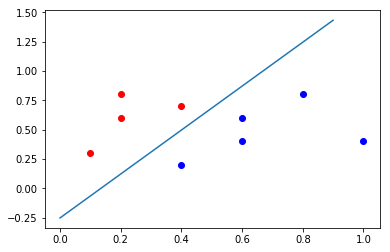

In [32]:
plt.figure()
plt.scatter(x_data.numpy()[:4,0],x_data.numpy()[:4,1] , marker='o', color='red')
plt.scatter(x_data.numpy()[4:,0],x_data.numpy()[4:,1] , marker='o', color='blue')
plt.plot(line_x,line_y)
plt.show()

## 用PyTorch类实现Logistic regression,torch.nn.module写网络结构

In [106]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(dim_in, dim_out)
    
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [107]:
model = Model()

In [108]:
# 定义 Loss 和 优化方法
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [109]:
tmp_test = Variable(torch.Tensor([[0, 1.0]]))
tmp_pred = model(tmp_test)
print("predict (before train)",tmp_test, "is" , 1 / (1 + np.exp(-float(tmp_pred.data))) >0.5)

predict (before train) tensor([[0., 1.]]) is False


In [110]:
epochs = 1000
loss_ = []
for epoch in range(epochs):
    # 计算 grads and cost
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss_.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #optimizer.zero_grad()

ValueError: Target size (torch.Size([200])) must be the same as input size (torch.Size([200, 1]))

In [38]:
tmp_test = Variable(torch.Tensor([[0, 1.0]]))
tmp_pred = model(tmp_test)
print("predict (after train)",tmp_test, "is" , 1 / (1 + np.exp(-float(tmp_pred.data))) >0.5)

predict (after train) tensor([[0., 1.]]) is True


In [39]:
param_ = []
for param in model.parameters():
    print(param.data)
    param_.append(param.data.numpy())

tensor([[-5.6192,  2.3973]])
tensor([0.9659])


In [40]:
w1 = param_[0][0][0]
w2 = param_[0][0][1]
b = param_[1][0]

In [41]:
line_x = np.arange(10)/10
line_y = (-w1*line_x-b)/w2

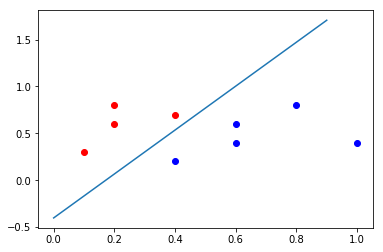

In [42]:
plt.figure()
plt.scatter(x_data.numpy()[:4,0],x_data.numpy()[:4,1] , marker='o', color='red')
plt.scatter(x_data.numpy()[4:,0],x_data.numpy()[4:,1] , marker='o', color='blue')
plt.plot(line_x,line_y)
plt.show()

In [43]:
n_data = torch.ones(10, 2)

In [48]:
n_data+2

tensor([[3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.],
        [3., 3.]])

In [45]:
x0 = torch.normal(2*n_data, 1)

In [46]:
x0

tensor([[1.3182, 1.4088],
        [2.2738, 1.0351],
        [1.7007, 3.8793],
        [1.9279, 2.1578],
        [1.2265, 2.1991],
        [2.0457, 2.1530],
        [4.6891, 1.8890],
        [2.2927, 1.8422],
        [1.9712, 4.3571],
        [0.9627, 3.5748]])

# Task4 用PyTorch实现多层网络

In [39]:
import torch.nn.functional as F
import torch.nn.init as init

In [40]:
import math
%matplotlib inline

### 读取样本

In [28]:
data = np.loadtxt("diabetes.csv",delimiter=',',skiprows=1,dtype=np.float32)
x_data = data[:,0:-1]
y_data = data[:,-1]

In [29]:
print(x_data.shape)
print(y_data.shape)

(768, 8)
(768,)


In [30]:
y_data[:4]

array([1., 0., 1., 0.], dtype=float32)

In [31]:
x_data = Variable(torch.from_numpy(x_data))
y_data = Variable(torch.from_numpy(y_data))

In [32]:
x_data

tensor([[  6.0000, 148.0000,  72.0000,  ...,  33.6000,   0.6270,  50.0000],
        [  1.0000,  85.0000,  66.0000,  ...,  26.6000,   0.3510,  31.0000],
        [  8.0000, 183.0000,  64.0000,  ...,  23.3000,   0.6720,  32.0000],
        ...,
        [  5.0000, 121.0000,  72.0000,  ...,  26.2000,   0.2450,  30.0000],
        [  1.0000, 126.0000,  60.0000,  ...,  30.1000,   0.3490,  47.0000],
        [  1.0000,  93.0000,  70.0000,  ...,  30.4000,   0.3150,  23.0000]])

### 建立网络模型

In [55]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        #建立网络 8*6*4*1
        self.l1 = torch.nn.Linear(8,6)
        self.l2 = torch.nn.Linear(6,4)
        self.l3 = torch.nn.Linear(4,1)
        
    def forward(self, x):
        out1 = F.relu(self.l1(x))
        out2 = F.dropout(out1, p = 0.5)
        out3 = F.relu(self.l2(out2))
        out4 = F.dropout(out3, p = 0.5)
        y_pred = F.sigmoid(self.l3(out3))
        return y_pred

In [71]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
        m.weight.data = torch.randn(m.weight.data.size()[0],m.weight.data.size()[1])
        m.bias.data = torch.randn(m.bias.data.size()[0])

In [72]:
model = Model()
model.apply(weights_init)

Model(
  (l1): Linear(in_features=8, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [73]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([768, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch = 0 loss = tensor(2.0959, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 100 loss = tensor(0.8207, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 200 loss = tensor(0.7271, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 300 loss = tensor(0.7061, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 400 loss = tensor(0.6606, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 500 loss = tensor(0.6574, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 600 loss = tensor(0.6603, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 700 loss = tensor(0.6623, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 800 loss = tensor(0.6532, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 900 loss = tensor(0.6416, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1000 loss = tensor(0.6443, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1100 loss = tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1200 loss = tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1300 loss = tensor(0.6425, grad_fn=<BinaryCrossEntropyB

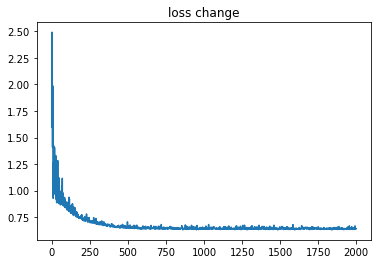

In [59]:
Loss = []
epochs = 2000
for epoch in range(epochs):
    
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    if epoch%100 == 0:
        print("epoch =", epoch, "loss =", loss)
    Loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(range(epochs), Loss)
plt.title(u"loss change")
plt.show()

# Task5 PyTorch实现L1，L2正则化以及Dropout

## 一、Dropout 原理

相关论文[Improving neural networks by preventing
co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf)

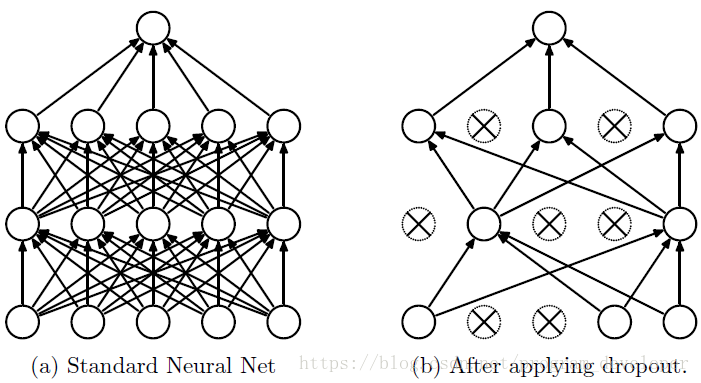

dropout的原理在网络上来说的话，如上图所示，就是在每层随机的选出一些点，从网络中去掉。这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征

在具体实现上，并不改变网络结构，只是将随机选出的点的值置为0。
同时要注意的一点是，若每个节点的值被置为0的概率是P，则在传播时，其他没有被置为0的节点的值要除以(1-P)

pytorch里也是如此实现的：
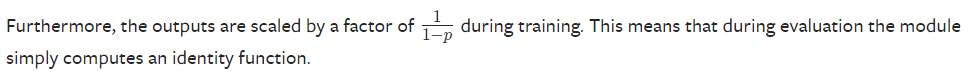

### 测试代码如下

可以看到`b`和`b1`的非0值是一样的

In [84]:
p = 0.2
a = torch.randn((3,4))
a

tensor([[-0.7114, -0.4478,  0.9447, -0.0425],
        [-2.1025,  1.7351, -2.8407, -0.1424],
        [ 0.0628, -1.4857,  0.7553,  0.3423]])

In [85]:
b = a/(1-p)
b

tensor([[-0.8893, -0.5597,  1.1809, -0.0531],
        [-2.6281,  2.1689, -3.5509, -0.1780],
        [ 0.0785, -1.8571,  0.9441,  0.4279]])

In [86]:
b1 = F.dropout(a, p = p)
b1

tensor([[-0.8893, -0.5597,  1.1809, -0.0000],
        [-2.6281,  0.0000, -3.5509, -0.0000],
        [ 0.0785, -0.0000,  0.9441,  0.0000]])

### 缩放的原理

当训练好网络时，若在测试样本时，也dropout，则会导致同一个样本，两次通过网络后得到的结果不一样。所以在测试时，网络不能使用dropout.

那么就是训练时用dropout，在测试时不用，那么就会导致一个问题：训练时的网络结构和测试时的网络结构不一致，比如一个5*3的网络：
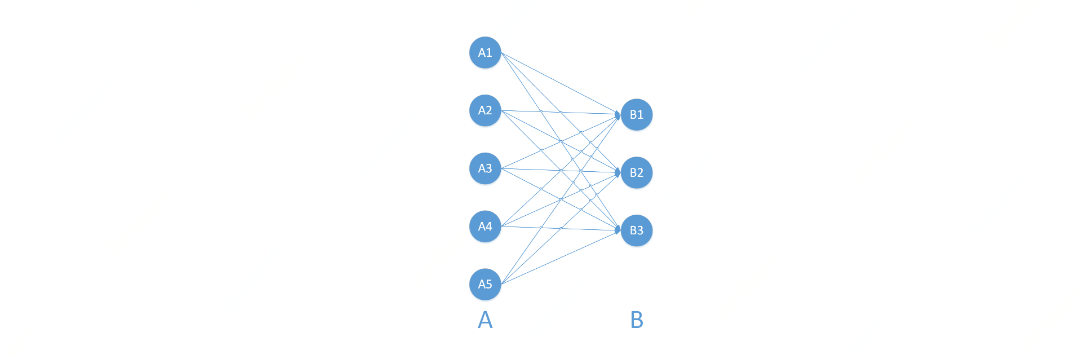

若p=0.2，假设A1被dropout掉了

训练时：B1是由A2~5的加权和组成的

测试时：B1是由A1~5的加权和组成的

**那么如果想要保持一致，就需要在训练时补偿**

训练时：$E\left(B_{1}\right)=\sum_{i=1}^{5} A_{i} \times(1-p) \times W_{i}=(1-p) \sum_{i=1}^{5} A_{i} \times W_{i}$

测试时：$E\left(B_{1}\right)=\sum_{i=1}^{5} A_{i} \times W_{i}$

改造训练时的期望计算方式：$E\left(B_{1}\right)=(1-p) \sum_{i=1}^{5} \frac{A_{i}}{1-p} \cdot W_{2}$

**也就是在训练时，每个节点的值需要除以(1-p)，这样测试时，去掉dropout就能保持一致了**

## 二、Dropout Numpy 实现

首先阅读了一下pytorch的关于dropout的底层实现，是用C++写的，包含的功能比较全，比如feature_dropout、alpha_dropout等等

代码如下:

```C++
template<bool feature_dropout, bool alpha_dropout, bool inplace, typename T>
Ctype<inplace> _dropout_impl(T& input, double p, bool train) {
  AT_CHECK(p >= 0 && p <= 1, "dropout probability has to be between 0 and 1, but got ", p);
  if (p == 0 || !train) {
    return input;
  }

  if (p == 1) {
    return multiply<inplace>(input, at::zeros({}, input.options()));
  }

  at::Tensor b; // used for alpha_dropout only
  auto noise = feature_dropout ? make_feature_noise(input) : at::empty_like(input);
  noise.bernoulli_(1 - p);
  if (alpha_dropout) {
    constexpr double alpha = 1.7580993408473766;
    double a = 1. / std::sqrt((alpha * alpha * p + 1) * (1 - p));
    b = noise.add(-1).mul_(alpha * a).add_(alpha * a * p);
    noise.mul_(a);
  } else {
    noise.div_(1 - p);
  }

  if (!alpha_dropout) {
    return multiply<inplace>(input, noise);
  } else {
    return multiply<inplace>(input, noise).add_(b);
  }
}
```

我抽出普通dropout的功能，仿照实现了一个

#### 1、首先确认功能

* 训练的时候使用dropout, 测试的时候不使用
* 能够随机选择节点drop掉

#### 2、代码实现

In [43]:
def dropout(data, p, train=True):
    if p == 0 or train != True:#无需做变化的情况
        return data 
    if p == 1:
        return np.zeros(data.shape)
    
    
    e = np.random.binomial(n=1,p=1-p,size=data.shape) #一次概率是1-p的贝努力试验
    return data*e

#### 3、将task4中的dropout的代码替换用numpy实现的

In [99]:
class Model_numpy(torch.nn.Module):
    
    def __init__(self):
        super(Model_numpy, self).__init__()
        
        #建立网络 8*6*4*1
        self.l1 = torch.nn.Linear(8,6)
        self.l2 = torch.nn.Linear(6,4)
        self.l3 = torch.nn.Linear(4,1)
        
    def forward(self, x):
        out1 = F.relu(self.l1(x))
        out2 = dropout(out1.data.numpy(), p = 0.5)
        out3 = F.relu(self.l2(torch.from_numpy(out2).float()))
        out4 = dropout(out3.data.numpy(), p = 0.5)
        y_pred = F.sigmoid(self.l3(torch.from_numpy(out4).float()))
        return y_pred

In [100]:
model = Model_numpy()
model.apply(weights_init)

Model_numpy(
  (l1): Linear(in_features=8, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [101]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([768, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch = 0 loss = tensor(5.0146, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 100 loss = tensor(2.0202, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 200 loss = tensor(0.6997, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 300 loss = tensor(0.6780, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 400 loss = tensor(0.6814, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 500 loss = tensor(0.7386, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 600 loss = tensor(0.6484, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 700 loss = tensor(0.6893, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 800 loss = tensor(0.6634, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 900 loss = tensor(0.6884, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1000 loss = tensor(0.6997, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1100 loss = tensor(0.6623, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1200 loss = tensor(0.6896, grad_fn=<BinaryCrossEntropyBackward>)
epoch = 1300 loss = tensor(0.6643, grad_fn=<BinaryCrossEntropyB

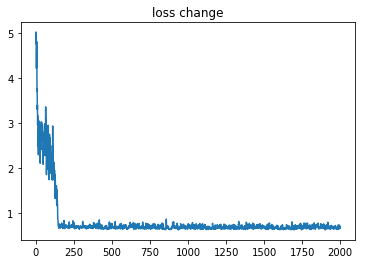

In [102]:
Loss = []
epochs = 2000
for epoch in range(epochs):
    
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    if epoch%100 == 0:
        print("epoch =", epoch, "loss =", loss)
    Loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(range(epochs), Loss)
plt.title(u"loss change")
plt.show()

## 三、加入L1、L2正则

### 理论

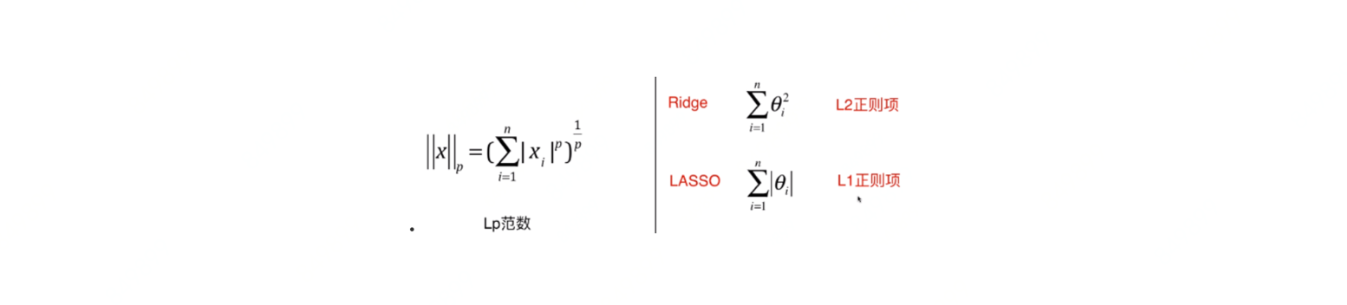

加入L1、L2正则的目的是降低模型的复杂度，避免过拟合

$\lambda > 0$

损失函数加上L1正则项（lasso回归）:

$L(x, y) = \sum_{i=1}^{n}\left(y_{i}-h_{\theta}\left(x_{i}\right)\right)^{2}+{\lambda \sum_{i=1}^{n}\left|\theta_{i}\right|}$

加上L2正则项（岭回归）:

$L(x, y) = \sum_{i=1}^{n}\left(y_{i}-h_{\theta}\left(x_{i}\right)\right)^{2}+\lambda \sum_{i=1}^{n} \theta_{i}^{2}$

#### l1 相比于 l2 容易获得稀疏解，为什么？

参考[l1 相比于 l2 为什么容易获得稀疏解？](https://www.zhihu.com/question/37096933/answer/70426653)

稀疏的意思就是，在L的极小值点处，一些$\theta$的值为0。若要达到这种效果，就需要在加上正则项后，L在$\theta = 0$处的左右两边的导数异号

**在L1正则上来看的话：**

$L(x, y) = L_{1}(x, y)+{\lambda \sum_{i=1}^{n}\left|\theta_{i}\right|}$

$L_{左}^{\prime}(0) * L_{右}^{\prime}(0)=\left(L_{1}^{\prime}(0)-\lambda\right)\left(L_{1}^{\prime}(0)+\lambda\right)<0$

所以只需要 $\lambda>\left|L_{1}^{\prime}(0)\right|$ ， $\lambda$ 越大，越多的$\theta_{i}$ 会变成0

**在L2正则上来看的话：**

在$\theta = 0$的附近，因为<1,是小数，相比于L1，更不容易使左右两边的导数异号

In [58]:
def l1_penalty(var):
    return torch.abs(var).sum()

def l2_penalty(var):
    return torch.pow(var, 2).sum()

In [59]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        #建立网络 8*6*4*1
        self.l1 = torch.nn.Linear(8,6)
        self.l2 = torch.nn.Linear(6,4)
        self.l3 = torch.nn.Linear(4,1)
        
    def forward(self, x):
        out1 = F.relu(self.l1(x))
        out2 = F.dropout(out1, p = 0.5)
        out3 = F.relu(self.l2(out2))
        out4 = F.dropout(out3, p = 0.5)
        y_pred = F.sigmoid(self.l3(out3))
        return y_pred

In [60]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
        m.weight.data = torch.randn(m.weight.data.size()[0],m.weight.data.size()[1])
        m.bias.data = torch.randn(m.bias.data.size()[0])

In [106]:
model = Model()
model.apply(weights_init)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

加入L1正则

C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([768, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch = 0 loss = tensor(13.6052, grad_fn=<AddBackward0>)
epoch = 100 loss = tensor(5.9685, grad_fn=<AddBackward0>)
epoch = 200 loss = tensor(5.2678, grad_fn=<AddBackward0>)
epoch = 300 loss = tensor(4.6055, grad_fn=<AddBackward0>)
epoch = 400 loss = tensor(4.0718, grad_fn=<AddBackward0>)
epoch = 500 loss = tensor(3.5651, grad_fn=<AddBackward0>)
epoch = 600 loss = tensor(3.1281, grad_fn=<AddBackward0>)
epoch = 700 loss = tensor(2.6415, grad_fn=<AddBackward0>)
epoch = 800 loss = tensor(2.3048, grad_fn=<AddBackward0>)
epoch = 900 loss = tensor(2.0240, grad_fn=<AddBackward0>)
epoch = 1000 loss = tensor(1.7804, grad_fn=<AddBackward0>)
epoch = 1100 loss = tensor(1.5516, grad_fn=<AddBackward0>)
epoch = 1200 loss = tensor(1.3759, grad_fn=<AddBackward0>)
epoch = 1300 loss = tensor(1.2576, grad_fn=<AddBackward0>)
epoch = 1400 loss = tensor(1.1499, grad_fn=<AddBackward0>)
epoch = 1500 loss = tensor(1.0658, grad_fn=<AddBackward0>)
epoch = 1600 loss = tensor(0.9917, grad_fn=<AddBackward0>)
epoch = 

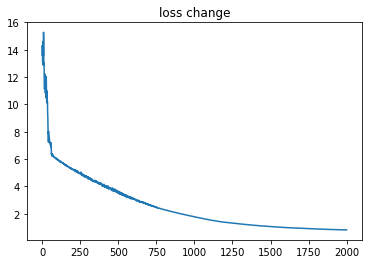

In [107]:
Loss = []
epochs = 2000

for epoch in range(epochs):
    l1 = 0 #这里注意，一定要在循环里定义，这样每次循环后就会释放图，否则会报错
    y_pred = model(x_data)
    for param in model.parameters(): #循环计算每一层的参数
        l1 += l1_penalty(param)
    loss = criterion(y_pred, y_data) + 0.1*l1
    if epoch%100 == 0:
        print("epoch =", epoch, "loss =", loss)
    Loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(range(epochs), Loss)
plt.title(u"loss change")
plt.show()

加入L2正则

C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\liyanqi3\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([768, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch = 0 loss = tensor(21.9936, grad_fn=<AddBackward0>)
epoch = 100 loss = tensor(7.5321, grad_fn=<AddBackward0>)
epoch = 200 loss = tensor(5.1420, grad_fn=<AddBackward0>)
epoch = 300 loss = tensor(3.6417, grad_fn=<AddBackward0>)
epoch = 400 loss = tensor(2.6533, grad_fn=<AddBackward0>)
epoch = 500 loss = tensor(1.9944, grad_fn=<AddBackward0>)
epoch = 600 loss = tensor(1.5550, grad_fn=<AddBackward0>)
epoch = 700 loss = tensor(1.2613, grad_fn=<AddBackward0>)
epoch = 800 loss = tensor(1.0649, grad_fn=<AddBackward0>)
epoch = 900 loss = tensor(0.9341, grad_fn=<AddBackward0>)
epoch = 1000 loss = tensor(0.8457, grad_fn=<AddBackward0>)
epoch = 1100 loss = tensor(0.7874, grad_fn=<AddBackward0>)
epoch = 1200 loss = tensor(0.7475, grad_fn=<AddBackward0>)
epoch = 1300 loss = tensor(0.7213, grad_fn=<AddBackward0>)
epoch = 1400 loss = tensor(0.7036, grad_fn=<AddBackward0>)
epoch = 1500 loss = tensor(0.6918, grad_fn=<AddBackward0>)
epoch = 1600 loss = tensor(0.6839, grad_fn=<AddBackward0>)
epoch = 

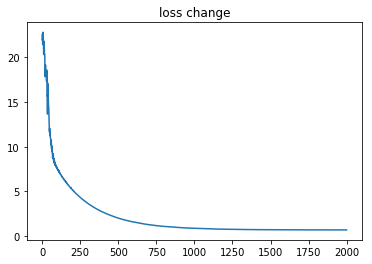

In [103]:
Loss = []
epochs = 2000

for epoch in range(epochs):
    l2 = 0 #这里注意，一定要在循环里定义，这样每次循环后就会释放图，否则会报错
    y_pred = model(x_data)
    for param in model.parameters(): #循环计算每一层的参数
        l2 += l2_penalty(param)
    loss = criterion(y_pred, y_data) + 0.1*l2
    if epoch%100 == 0:
        print("epoch =", epoch, "loss =", loss)
    Loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(range(epochs), Loss)
plt.title(u"loss change")
plt.show()